In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
joints = np.array([
    [0, 0],
    [1, 0],
    [2, 0],
])
minx, maxx = -1.5, 3.5
miny, maxy = -2.5, 2.5

skinning_width = 3

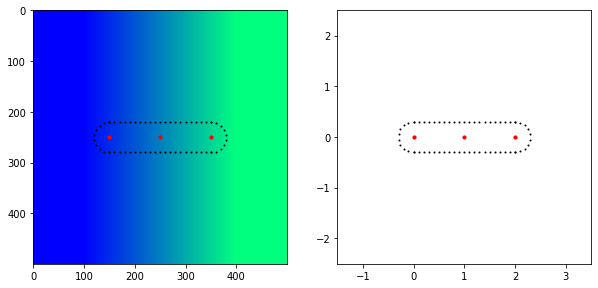

In [3]:
def get_w(v, width=1):
    w1 = (v[:, 0] - joints[1, 0]) / width + 0.5
    w1 = w1.clip(0, 1)
    w0 = 1 - w1
    result = np.concatenate((w0.reshape(-1, 1), w1.reshape(-1, 1)), axis=1)
    return result

def get_w1_img(h, w, minx, maxx, miny, maxy, width=1):
    w1_img = np.zeros((h, w))
    for xi, x in enumerate(np.linspace(minx, maxx, 500)):
        for yi, y in enumerate(np.linspace(miny, maxy, 500)):
            w1_img[yi, xi] = get_w(np.array((x, y)).reshape(1, 2), width=width)[0, 1]
    return w1_img

def coords_to_img_space(v, h, w):
    v_img_space = v.copy()
    v_img_space[:, 0] = (v[:, 0] - minx) / (maxx - minx) *  w
    v_img_space[:, 1] = (v[:, 1] - miny) / (maxy - miny) *  h
    return v_img_space

def get_vertices(joints, r=.3, density=10):
    vertices = []
    for a in np.linspace(np.pi / 2, np.pi / 2 + np.pi, density):
        dx = r * np.cos(a)
        vx = joints[0, 0] + dx
        dy = r * np.sin(a)
        vy = joints[0, 1] + dy
        vertices.append((vx, vy))

    for x in np.linspace(joints[0, 0], joints[-1, 0], 2 * density + 1):
        vertices.append((x, joints[0, 0] + dy))

    for a in np.linspace(-np.pi / 2, -np.pi / 2 + np.pi, density):
        dx = r * np.cos(a)
        vx = joints[-1, 0] + dx
        dy = r * np.sin(a)
        vy = joints[-1, 1] + dy
        vertices.append((vx, vy))

    for x in np.linspace(joints[0, 0], joints[-1, 0], 2 * density + 1):
        vertices.append((x, joints[0, 0] + dy))
    vertices = np.array(vertices)
    return vertices

vertices = get_vertices(joints)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
h, w = 500, 500
w1_img = get_w1_img(h, w, minx, maxx, miny, maxy, width=skinning_width)
axs[0].imshow(w1_img, cmap='winter')
axs[0].scatter(coords_to_img_space(vertices, h, w)[:, 0], coords_to_img_space(vertices, h, w)[:, 1], s=1, c='k')
axs[0].scatter(coords_to_img_space(joints, h, w)[:, 0], coords_to_img_space(joints, h, w)[:, 1], s=10, c='r')

axs[1].scatter(vertices[:, 0], vertices[:, 1], s=1, c='k')
axs[1].scatter(joints[:, 0], joints[:, 1], s=10, c='r')
axs[1].set_xlim(minx, maxx)
axs[1].set_ylim(miny, maxy)

axs[0].set_aspect(1.0)
axs[1].set_aspect(1.0)
plt.show()

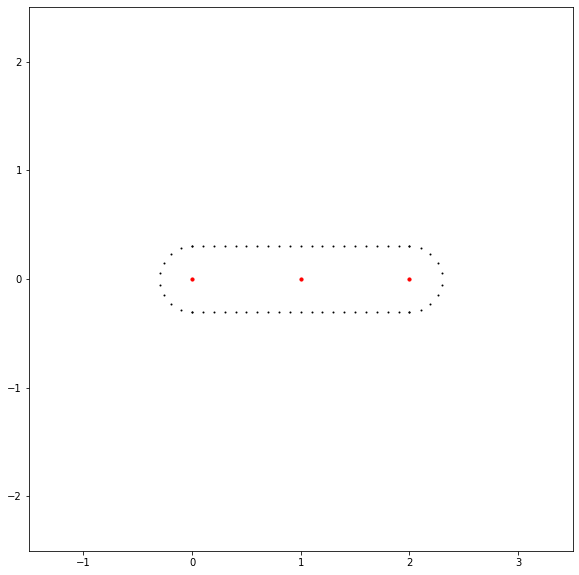

In [4]:
def angle2rotmtx(a):
    c, s = np.cos(a), np.sin(a)
    R = np.array(((c, -s), (s, c)))
    return R

def transform_mtx(rotmtx, translation):
    result = np.eye(3)
    result[:2, :2] = rotmtx
    result[:2, [2]] = translation.reshape(2, 1)
    return result

def apply_pose_to_vertices(vertices, joints, pose):
    # coord systems:
    # 1) joint coord space (for joint coords it does not matter if it is canonical or posed space)
    # 2) global coord space
    #   2a) global coord space in canonical space (when palka is flat)
    #   2b) global coord space in posed space (when palka is moving)


    # transformation matrix for joint 0 in global coords in canonical space
    canonical_global_0 = transform_mtx(np.eye(2), joints[0])  # our palka is flat -> no rotation in canonical space

    # rotation for joint 0 in joint coords 
    local_r0 = angle2rotmtx(pose[0])

    global_r0 = local_r0
    global_t0 = joints[0]
    # transformation matrix for joint 0 in global coords in posed space
    posed_global_0 = transform_mtx(global_r0, global_t0)


    # transformation matrix for joint 1 in global coords in canonical space
    canonical_global_1 = transform_mtx(np.eye(2), joints[1])  # our palka is flat -> no rotation in canonical pose

    # transformation matrix for all joints in global coords in canonical space
    canonical_global = np.stack((canonical_global_0, canonical_global_1))
    canonical_global_inv = np.stack((
        np.linalg.inv(canonical_global_0), 
        np.linalg.inv(canonical_global_1)))

    # transformation matrix for joint 1 in global coords in posed space
    # TODO 1: understand formula
    wtf_transform = transform_mtx(angle2rotmtx(pose[1]), joints[1] - joints[0])
    posed_global_1 = posed_global_0 @ wtf_transform

    # transformation matrix for all joints in global coords in posed space
    posed_global = np.stack((posed_global_0, posed_global_1))

    # (62, 2) 
    # skinning weights for all joints
    # !!!! for forward skinning skinning weights are set in canonical space
    ws = get_w(vertices, width=skinning_width)

    # use homogeneous coordinate system to apply 3x3 transormation mtx
    vertices_homo = np.concatenate((vertices, np.ones((len(vertices), 1))), axis=1)

    # t - joint index, 2
    # n - vertice index, 62
    # i, j - axis index, 3

    # (2, 3, 3), (62, 3) -> (2, 3, 62)
    vertices_in_joint_coord = np.einsum('tij,nj->tin', canonical_global_inv, vertices_homo)

    # (2, 3, 62) -> (2, 62, 3)
    # coordinates of vertices in joint coords
    vertices_in_joint_coord = np.swapaxes(vertices_in_joint_coord, 1, 2)

    # (2, 3, 3), (2, 62, 3) -> (2, 3, 62, 3)
    vertices_in_global_posed_coord = np.einsum('tij,tnj->tin', posed_global, vertices_in_joint_coord)

    # (2, 3, 62) -> (2, 62, 3)
    vertices_in_global_posed_coord = np.swapaxes(vertices_in_global_posed_coord, 1, 2)

    # (2, 62, 3), (62, 2) -> (62, 3)
    weighted_vertices_in_global_posed_coord = np.einsum('tnj,nt->nj', vertices_in_global_posed_coord, ws)
    result = weighted_vertices_in_global_posed_coord
    
    return result


def animate(i):
#     if i % 30 == 0: print(i)
    ax.clear()
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    theta0 = .2 * np.sin(2 * np.pi * 3 / frames * i)
    theta1 = 1.3 * np.sin(2 * np.pi * 5 / frames * i)
    
    posed_vertices = apply_pose_to_vertices(vertices, joints, pose=[theta0, theta1])
    posed_joints = apply_pose_to_vertices(joints, joints, pose=[theta0, theta1])
    scatter1 = ax.scatter(posed_vertices[:, 0], posed_vertices[:, 1], s=1, c='k')
    scatter2 = ax.scatter(posed_joints[:, 0], posed_joints[:, 1], s=10, c='r')
#     return scatter1, scatter2


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect(1.0)
frames = 600
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=1000 / 60)
anim.save('palka_boltalka.gif', writer='pillow')

# plt.draw()
# plt.show()

## TODO 2

Visualize skinning weights in posed space

In [5]:
# your code here